In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('honors_thesis.mplstyle')

# Hillslope Definition

In this study, a hillslope consists of a soil mantle that overlies a layer of saprolite, which in turn overlies bedrock (Figure 2). The soil mantle is physically mobile and subject to mechanical erosion and the saprolite is chemically mobile and subject to chemical erosion (Dixon and Riebe, 2014). Bedrock is also chemically mobile and chemical dissolution is responsible for converting bedrock to weathered saprolite (Jin et al., 2010); however, in our model we account only for one dissolution process, which might be considered as the dissolution of saprolite or an inclusive (but undistin- guished) dissolution of saprolite and bedrock

<img src="src_images/definition_hillslope.png" width="400">

We model the mechanical erosion of the soil mantle with the linear diffusion equation, which is well defined in the literature (Culling, 1960, Furbish and Fagherazzi, 2001). Erosion dude to chemical dissolution at the hills- lope scale, however, is not. We formulate an original model with the following assumptions. Dissolution of saprolite material occurs only in the upper layers of saprolite and is caused by the infiltration of water from above the soil-saprolite interface. In response to a rainstorm, water infiltrates through the soil column and a perched water table forms above the soil-saprolite in- terface (Scanlon et al., 2000) because the hydraulic conductivity of sapro- lite is much less than that of soil. Water perched on top of the soil-saprolite interface simultaneously flows downslope atop the saprolite layer and infil- trates vertically downward into the saprolite. The perched water table rises above the soil-saprolite interface at the onset of a rainstorm, rises throughout the length of the rainstorm, and begins draining when the rainstorm ends. When the water table drains below the soil-saprolite interface, water ceases to flow into the saprolite and any continuing mineral dissolution is negligible.


To model both mechanical and chemical processes occurring on a hillslope, we need a mathematical description of hillslope geometry. We describe the profile concavity of the hillslope, how elevation varies between the crest and the bottom of the hillslope, and the planform, how elevation varies parallel to a stream channel positioned at the bottom of the hills- lope. We place our hillslope in a Cartesian coordinate system, with the x-axis normal to and the z-axis parallel to the direction of gravity (Figure 2). The crest of the hillslope is at x = 0 and the hillslope extends down- wards in the positive x direction. The boundary at x = 0 forms a no flux boundary; no water or soil enters or exits the hillslope laterally. The bot- tom edge of the hillslope is at x = L, where we imagine a stream channel (Figure 1) that transports away all mass brought into it. Soil and water can only leave the hillslope from the bottom, at x = L.

## Hillslope Profile

Kirkby (1971) found that hillslopes generally take on three forms – convex, planar, and concave – depending on the transport processes operating on them. In their study of subsurface flow, Fan and Bras (1998) use a second order polynomial of the form

\begin{equation}
    \zeta(x) = \gamma + \beta x + \alpha x^2
\end{equation}

where $\gamma$ is the height of the hillslope at the crest, $\beta$ is the slope at the crest, and $\alpha$ is the rate of change of slope with respect to $x$, or concavity. Using this polynomial, we define a single convex hillslope due to the frequent use of convex parabolic hillslopes in geomorphological studies (Figure 3). We assume that the soil column thickness, $H$, is on the order of a meter and is spatially uniform such that the soil-saprolite interface, where the perched water table forms, is a downwards translation of the land surface,

\begin{equation}
    \eta(x) = \gamma - H + \beta x + \alpha x^2.
\end{equation}

We use the geometry of the soil-saprolite interface ($\eta$) to explore the dynamics of perched water table flow (and chemical erosion) and we use the geometry of the land surface ($\zeta$) (or, equivalently, soil surface) to describe mechanical soil transport with the linear diffusion model.

### Define parameters

The rest of the project will rely heavily on how the hillslope geometries are defined. We recommend the following parameters.

| Hill type | $\beta$, slope at ridge | $\alpha$, concavity |
| ------------- |-------------| -----|
| Convex  | -0.01 | -0.005 |
| Planar  | -0.51 | 0.0 |
| Concave | -1.01 | 0.005 |

These parameters are chosen such that the steepest angle of any hillslope profile (at $L = 100$) is 45°. This geometry is consistent with those of soil mantled hillslopes found in humid climates, such as the hills of the Appalachians and the eastern United States.

### Plot Hillslope Profiles

In [15]:
ridgeSlope = -0.01 # m/m, initial slope/slope at ridge
concavity = -0.005 #m^-1, concavity/rate of change of slope, restrict 
hillLength = 100.0 # meters, horizontal extent of hillslope
ridgeElev = 50.0 #meters, elevation at ridge
dx = 1.0 # space step
xRes = int(hillLength/dx) #spatial resolution for modelling and plotting
kSat = 10**-3 #meters/sec, saturated hydraulic conductivity of the soil
precip = 0.01/3600 #m/sec, precipitation rate
drainage = -precip*0.1 #m/sec, drainage rate into underlying saprolite
stormLength = 3600.0*3 #sec, length of rain storm

# Variable quality checks
assert (ridgeSlope < 0), "You cannot route water upslope!"
if concavity < 0: print("Convex hillslope")
elif concavity == 0: print("Planar hillslope")
else: print("Concave hillslope")
assert (abs(ridgeSlope) <= 1.01), "Your hillslope is getting too steep"

Convex hillslope


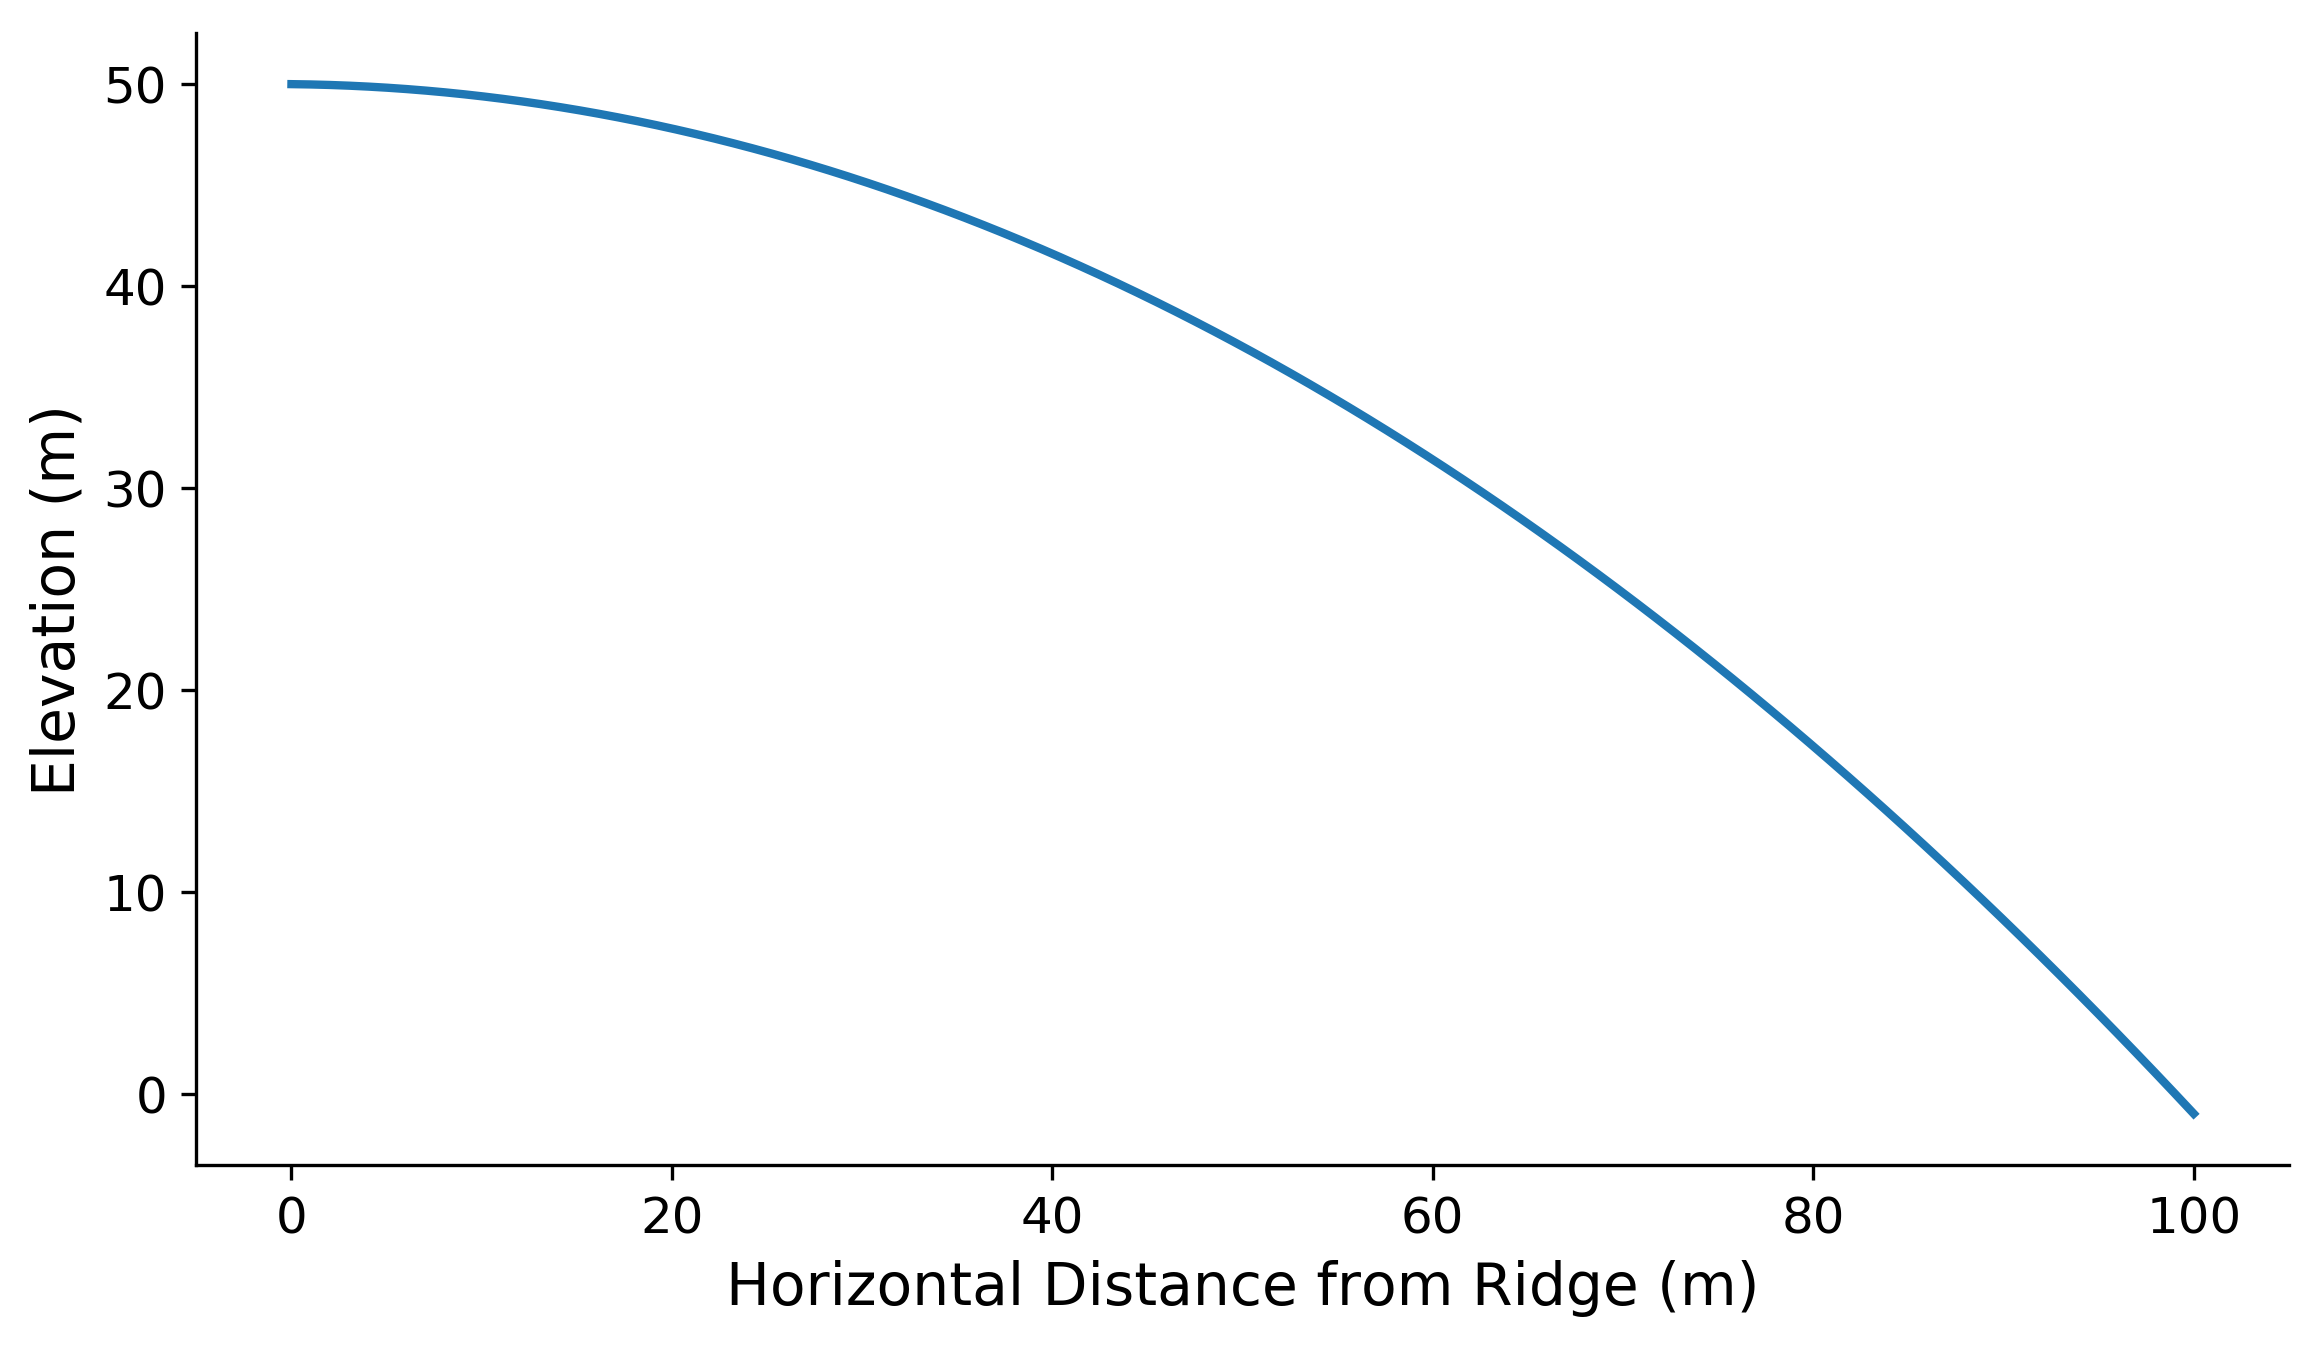

In [11]:
x = np.linspace(0,hillLength, xRes)
elevation = ridgeElev + ridgeSlope*x + concavity*x**2
elevationPlot = plt.plot(x, elevation)[0] # returns only 1 graph anyways
ax = elevationPlot.axes
ax.set_xlabel("Horizontal Distance from Ridge (m)");
ax.set_ylabel("Elevation (m)");
plt.show()

Try adjusting the `ridgeSlope` ($\beta$) and `concavity` ($\alpha$) variables to observe how the hillslope profile changes.

## Hillslope Planform

In addition to describing the profile of the hillslope, we must describe the plan shape of the hillslope. The plan shape determines whether the topography is convergent or divergent, which influences whether flow over the hillslope is convergent or divergent.

To keep the fluid dynamic equations simpler down the line, we will only describe the hillslope plan shape as linearly convergent or divergent. What we are essentially doing, mathematically, is bounding the flow of water at the edges our simulated section of hillslope. We ignore all lateral flow and assume that the height of the water surface above the surface over which it flows (descibed above with the parabolic equation) can be averaged over the hillslope section. 

A linear convergent or divergent hillslope section should have width that increases or decreases linearly downslope. We use a linear equation to relate hillslope width, $b$ and downslope distance, $x$,

\begin{equation}
    b = b_0 + c*x
\end{equation}

where $b_0$ is the width of the hill at the ridge ($x = 0$) and $c$ is the convergence rate, the constant rate of change of hillslope width. Because we want to keep the hillslope sections with different plan shapes of a constant surface area, we begin by defining the hillsope width at the midpoint, $b(x)$ where $x = L/2$, or $b_{mid}$.

For `hillLength = 100`, we recommend the following parameter values for various hillslopes.

| Plane shape    | $b_{mid}$ | $c$    |
| -------------  |-------|-------|
| Convergent     |   20  | -0.2  |
| Divergent      |   20  |  0.2  | 
| Uniform        |   20  |  0.0  | 

### Plot Hillslope Planform

To plot the plan shape of the hillslopes we plot the edges rather than the actual width for easier visualization.

Convergent hillslope


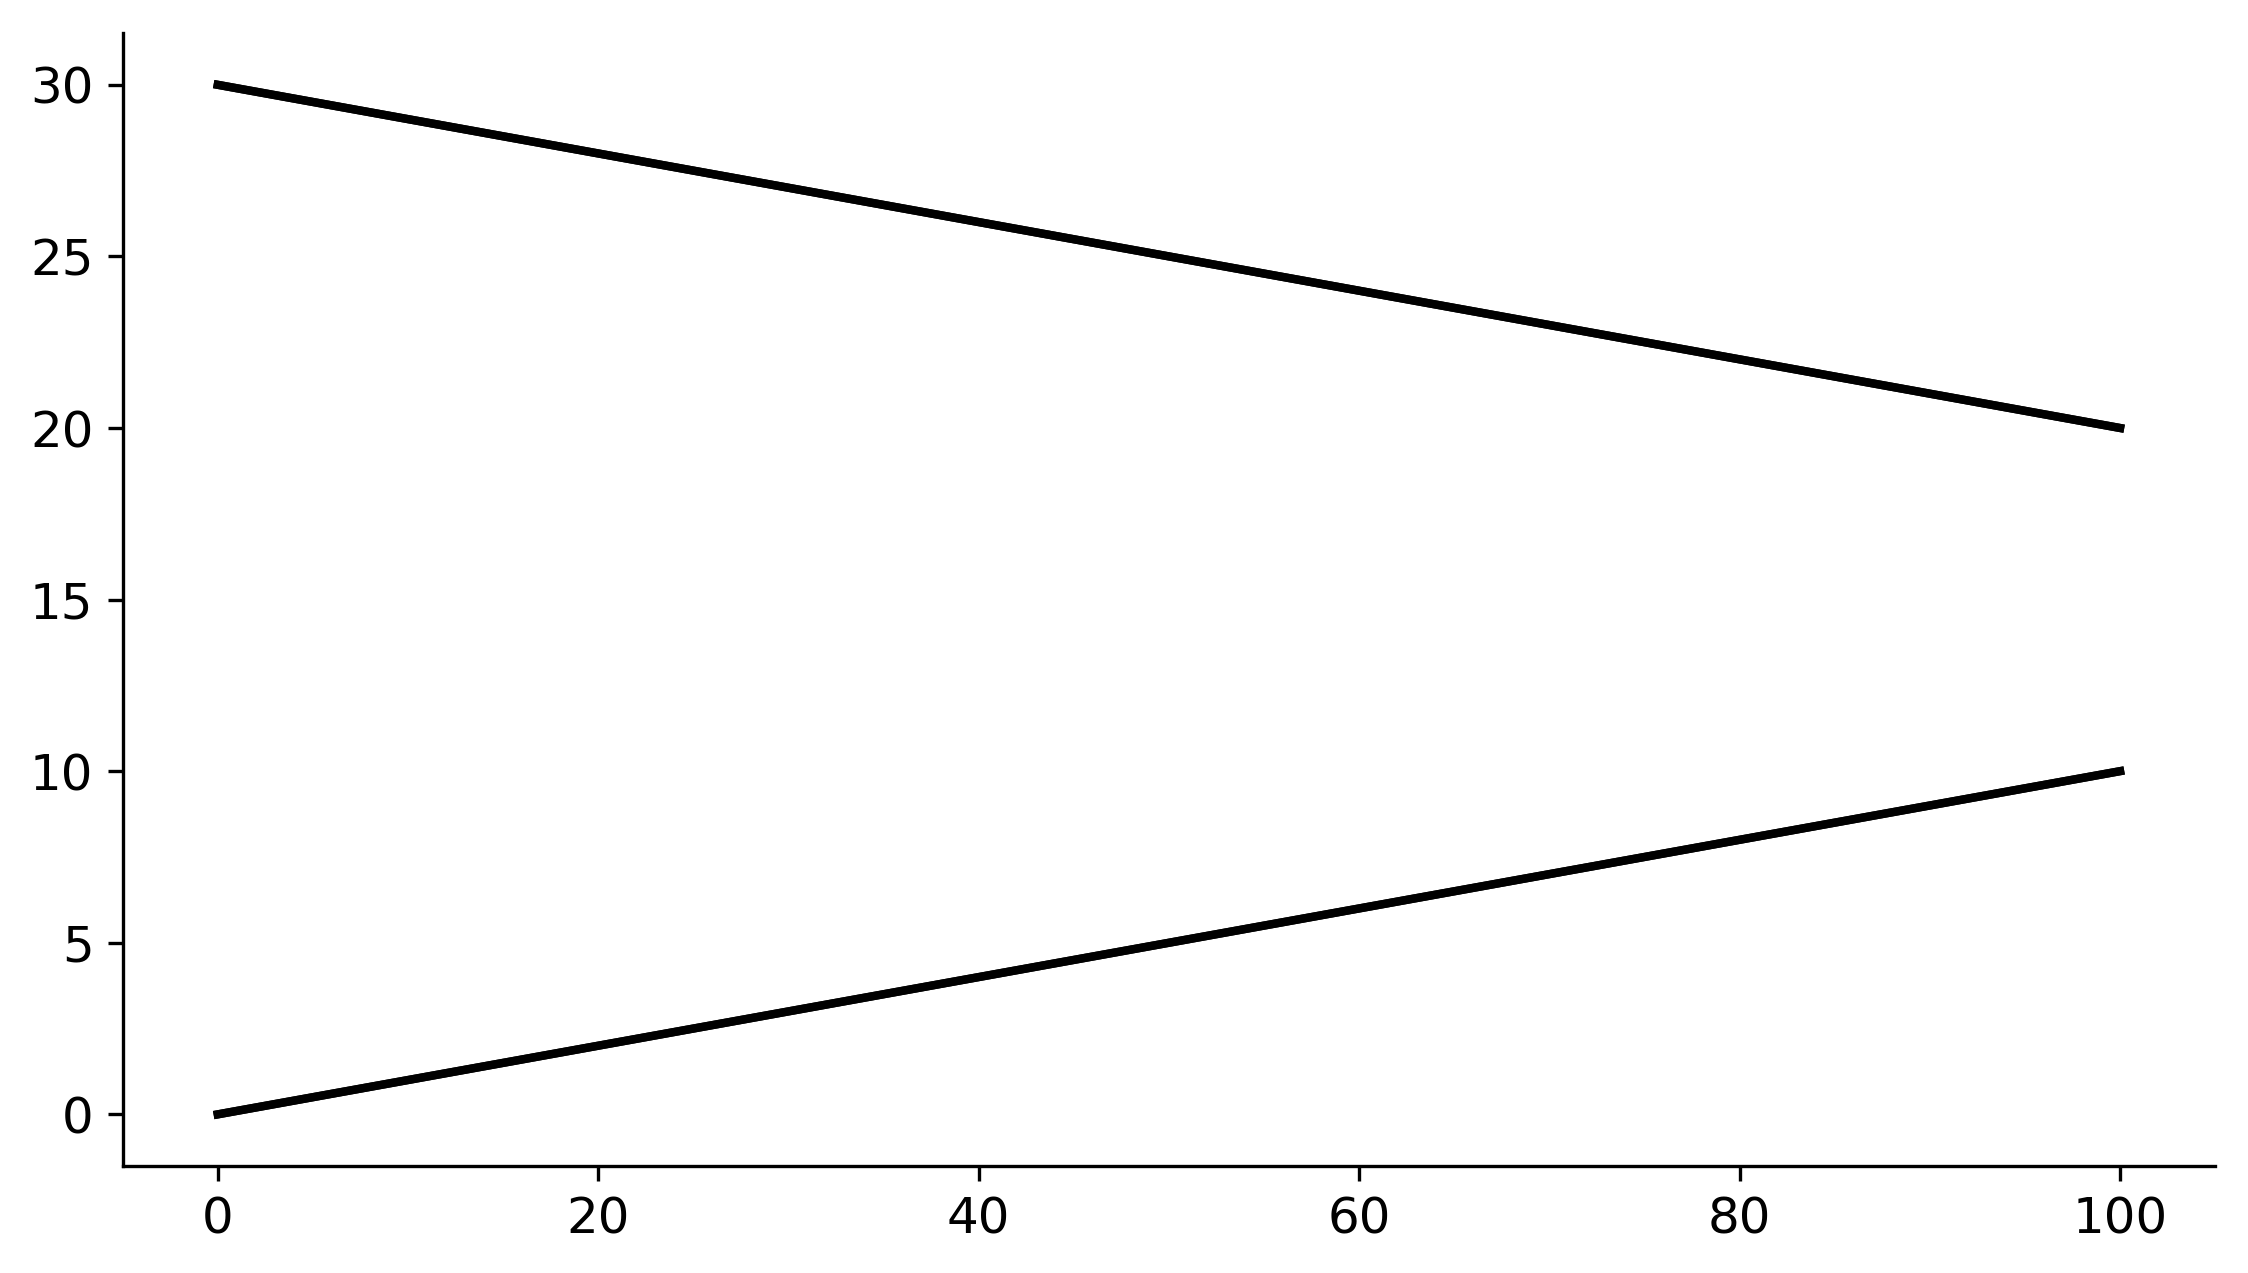

In [13]:
c = -0.2
bmid = 20

b0 = bmid - c*hillLength/2
bL = bmid + c*hillLength/2
w1 = 0.5*(bL - b0) - (c/2)*x + 10
w2 = (0.5*(bL - b0)+b0) + (c/2)*x + 10

plt.plot(x,w1, color = 'black');
plt.plot(x,w2, color = 'black');

if c < 0: print('Convergent hillslope')
elif c > 0: print('Divergent hillslope')
else: print('Uniform hillslope')
plt.show()

## 9 Characteristic Hillslope Forms

Using the 3 hillslope profiles (concave, planar, and convex) and the 3 hillslope planforms (convergent, uniform, divergent) we can imagine 9 distinct characteristic hillslope forms, which are summarized nicely in a figure from Troch et al. (2002).

<img src="src_images/troch_hillslopes.jpeg", width=500>

Although the hillslopes defined by Troch et al. (2002) are conic sections, the three hillslopes we model by imposing the linear contour width function on the quadratic profile equation are of the same basic character as those of Troch et al (2002). We can now use the nine hillslope forms to explore the dynamics of perched water table flow on a variety of hillslope/saprolite surfaces.

# Perched Water Table Flow

Now we turn to describing subsurface flow on different hillslope forms. Specifically, we want to calculate the height of a water table perched above the soil-saprolite interface as a function of space, $x$, and time, $ t $, in response to a single rainstorm. The perched water table will rise as it rains and lower as it drains after a rainstorm ends. The kinematic wave approximation allows us to analytically calculate the dynamics of a perched water table.

## Kinematic Wave Approximation for Perched Water Table Flow

Fluid flow on hillslopes in response to storms has been studied extensively in the fields of fluid dynamics and hydrology (Henderson and Wooding, 1964; Dunne and Leopold, 1978; Bevin, 1981; Giraldez and Woolhiser, 1996; Fan and Bras, 1998;  Scanlon et al., 2000; Troch et al., 2002). Flow on a one-dimensional sloping hillslope is often described with the Boussinesq equation, which, in its general form, has no analytical solutions (Troch et al., 2002). When the angle of the inclined surface is relatively large, the second-order diffusive term in the Boussinesq equation becomes negligible and the kinematic wave approximation, which essentially assumes that gravity is the only force acting on the fluid, becomes applicable (Henderson and Wooding, 1964; Bevin, 1981). The Boussinesq equation for a water table perched atop a permeable saprolite layer takes the form
\begin{equation}
    \frac{\partial h}{\partial t} + \frac{\partial}{\partial x} (h q_x) = N
\end{equation}
where $ h $ is the height of the perched water table above the soil-saprolite interface, $ q_x $ is flux of water in the positive $ x $ direction, and $ N $ is a combined source-sink term, which we define as a constant rainfall rate minus the infiltration rate of water into the saprolite layer, which is equal to the hydraulic conductivity of the saprolite (which we assume is spatially uniform). Assuming that the precipitation rate never comes close to reaching the infiltration capacity of the soil, the infiltration rate, $ N $, into the soil and into the perched water table, is equal to the precipitation rate. This assumption indicates that no Hortonian overland flow occurs on our hillslope, which is a safe assumption for relatively humid, forested, soil-mantled environments (Dunne and Leopold, 1978). To conserve fluid mass in our quasi two-dimensional framework, we include the contour width function, $ b(x) $, in each term of the above equation,

\begin{equation}
    \frac{\partial}{\partial t} (b(x) h) + \frac{\partial}{\partial x} (b(x) h q_x) = N b(x).
\end{equation}

The kinematic wave approximation assumes that flux of water, $ q_x $, is directly proportional to the slope of the surface over which it flows,

\begin{equation}
    q_x = - \frac{K_h}{\epsilon} \frac{d \eta}{d x} = K \frac{d \eta}{d x}
\end{equation}

where $ K_h $ is hydraulic conductivity, $ \epsilon $ is drainable porosity of the soil, and $ \frac{d \eta}{d x} $ is the slope of the soil-saprolite interface, the surface atop which water beneath the perched water table flows (as defined previously). We define effective hydraulic conductivity $ K = K_h/\epsilon $ for simplicity in the upcoming mathematics and assume that it is spatially uniform. Noting that $ b(x) $ and $ K $ do not vary with time, letting $ b $ denote $ b(x) $, and combining the 2 equations above, substituting our equations for contour width and hillslope profile from above, expanding and reorganizing, we find

\begin{equation}
    \frac{\partial h}{\partial t} - K (\beta + 2 \alpha x) \frac{\partial h}{\partial x} = N + K h \frac{c \beta + 4 \alpha c x + 2 \alpha b_0}{(b_0 + c x)}.
\end{equation}

This is a quasi-linear wave equation (Logan, 1987), a partial differential equation in the form of a wave equation with a source/sink term and a non-constant wave speed (the coefficient $ -K(\beta + 2 \alpha x) $). If $ N $ is constant, i.e. if rainfall rate and saprolite hydraulic conductivity are constant, the quasi-linear wave equation can be solved with the method of characteristics, which splits the equation into two ordinary differential equations (Logan, 1987; Fan and Bras, 1998; Troch et al., 2002),

\begin{equation}
    \frac{d x}{d t} = - K (\beta + 2 \alpha x),
\end{equation}

 which describes a family of characteristic curves in the x - t plane, and
 
\begin{equation}
\frac{d h}{d x} = - \frac{N}{K (\beta + 2 \alpha x)} - h(x,t) \frac{c \beta + 4 \alpha c x + 2 \alpha b_0}{(b_0 + c x)(\beta + 2 \alpha x)},
\end{equation}

which describes how the perched water table propagates along these curves (Fan and Bras, 1998; Troch et al., 2002). Note that we have replaced $ h $ with $ h(x,t) $ to clarify the dependent and independent variables in the differential equation.

In deriving the analytical solutions for the rise and decay of a perched water table on a hillslope, we follow the examples of Fan and Bras (1998) and Troch et al. (2002). It is worth noting that our model differs from each of their models in two respects. We allow water to drain into the surface over which it flows (similar to Giráldez and Woolhiser, 1996) while Fan and Bras and Troch restrict fluid movement to downslope flow over an impermeable surface (i.e. bedrock). Our hillslope forms are also uniquely defined by the combination of constant convergence rates and planar/parabolic hillslope forms. See the full report (Thesis.pdf) for the final solutions to the quasi-linear wave equation above (see sections 3.2 and 9.1).

## Plotting the Perched Water Table

The solutions to the quasi-linear wave equation describing the perched water table allow us to plot the water table, $h$, as a function of time $t$ and distance from the hillslope ridge $x$ after both the onset of a rainstorm and after the rainstorm has ended.

We must define the hydraulic conductivity of the saprolite and the length and intensity of a rainstorm to plot the water table. For simplicity, we have defined all necessary parameters in the `parameters.py` file. These parameters are imported into the various plotting functions. We now demonstrate the dynamics of the water table on the nine different hillslopes.

In [74]:
"""
Simple function for plotting the water table as it drains throughout 
a day. Overlays 4 water table plots at 0, 6, 12, and 24 hours after 
a rainstorm ends.
"""
from parameters import *
from plotWaterTable import plotWaterTable
drainTimes = [0, 6*3600, 12*3600, 24*3600]
def plotForEachDrainTime(planform, profile):
    plots = []
    xs = []
    for dt in drainTimes:
        res = plotWaterTable(planform,profile,dt)
        plt.plot(res[0],res[1],label=str(dt/3600) + " hrs")
    plt.xlim(0,100); plt.ylim(0,0.05)
    return plt.gcf()

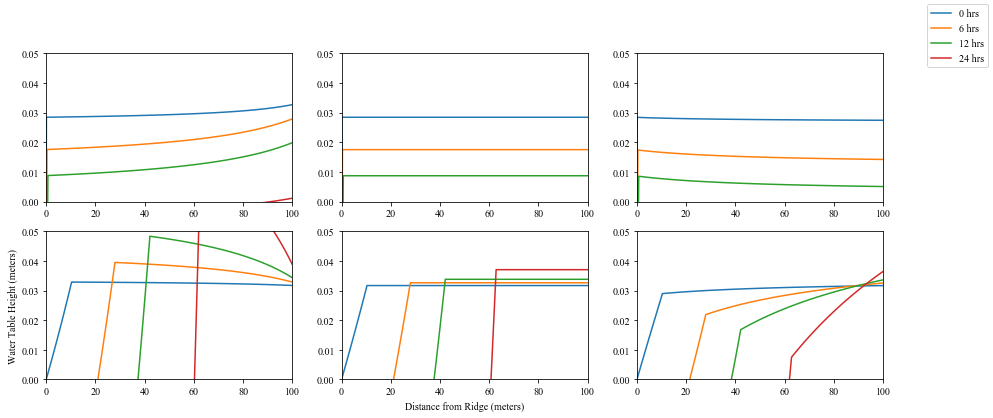

In [107]:
plt.figure(figsize=(15,6))
plt.subplot(2,3,1)
plotForEachDrainTime('con','convex')
plt.subplot(2,3,2)
plotForEachDrainTime('uni','convex')
plt.subplot(2,3,3)
plotForEachDrainTime('div','convex')
plt.subplot(2,3,4)
plotForEachDrainTime('con','concave')
plt.ylabel("Water Table Height (meters)")
plt.subplot(2,3,5)
plotForEachDrainTime('uni','concave')
plt.xlabel("Distance from Ridge (meters)")
plt.subplot(2,3,6)
plotForEachDrainTime('div','concave')
plt.figlegend()
plt.show()

In [105]:
fig,axs = plt.subplots(2,3,sharex=True,sharey=True,figsize=(15,6))

2

# References
Culling, W.E.H. Analytical theory of erosion. The Journal of Geology, Vol. 68, No. 3. 1960.

Dixon, J. and Riebe, C. Tracing and pacing soil across slopes. Elements. October 2014.

Furbish, D.J. and Fagherazzi, S. Stability of creeping soil and implications for hillslope evolution. Water Resources Research, Vol. 37. October 2001.

Jin, L et al. Mineral weathering and elemental transport during hillslope evolution at the Susquehanna/Shale Hills Critical Zone Observatory. Geochimica et Cosmochimica Acta 74. 2010.

Scanlon, Todd M, Clapp, Roger B. Shallow subsurface storm flow in a forested headwater catch- ment: Observations and modeling using a modified TOPMODEL. Water Resources Research, Vol. 36, No. 9. 2000.

Troch, P. et al. Analytical solutions to a hillslope-storage kinematic wave equation for subsurface flow. Advances in Water Resources, Vol. 25. February 2002